일반화 : 머신러닝은 결국 내가 있는 데이터를 기반으로 예측하는건데,
미지의 새로운데이터에도 똑같이 적용이 되는가?

새로운데이터에서도 성능을 유지하는 능력

과적합 : 훈련데이터에 과하게 ㅁ맞춰져서 일반화 성능이 저하

노이즈까지 학습시켜서 그래
머신러닝은 꼭 과적합 체크 여부가 들어가야해


kfold 교차 검증! > 7:3으로 쪼개는걸 여러번 해서 그거에 대한 평균 표준편차로...최소 5번 돌려서 종합적으로 판단


에러율로 판단
rmse의 표준편차를 rmse 평균으로 나눠
> 과적합 발생하면 데이터를 늘리면 해결되기도 함

처음에는 풀 세트,
스코어 이름


과적합의 종류를 알아야 개선이 가능함
과대 .과소.최적
1) 과대적합 -> 잡음까지 학습 (이상치 학습)
변수 수 줄이기 너무 ㅈ복잡한 모델이라 발생 잘함

2) 과소적합 -> 모델이 너무단순해서 학습을 못한거 > 변수가 부족한거

3) 행 수가 적으면 데이터 부족...

데이터를 추가 수집해도 에러율에 개선이 발생하지 않을떄...


cv_rmse > 일종의 연속형데이터 5번 나눳 테스트한 수치값들


훈련데이터 크기에 따른 에러율 / 검증데이터 에러율


리니어에서 과대적합 ? > 지도학습 못함, 비지도 or 규제 적용





# [LAB 06] 지도학습 > 예측 >선형 > 04-과적합의 이해
- 농어의 무게 예측 모형
<주요 포인트>
- 과적합의 정의와 직관적 의미
- 괒거합을 정량적으로 판정하는 방법
- 선형회귀에서 가능한 현실적 대응 전략

## #01.준비작업
### [1] 패키지 가져오기

In [1]:
from hossam import *
from pandas import DataFrame, read_excel
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
import statsmodels as sm

from itertools import combinations

#데이터 표준화 모듈
from sklearn.preprocessing import StandardScaler

#선형 회귀 분석 모듈
from sklearn.linear_model import LinearRegression

#훈련/검증 데이터 분리 모듈
from sklearn.model_selection import KFold,cross_val_predict,learning_curve,train_test_split

from scipy.stats import pearsonr,spearmanr


#성능 평가 지표 모듈
from sklearn.metrics import(
  r2_score,
  mean_absolute_error,
  mean_squared_error,
  mean_absolute_percentage_error
)

### [2] 데이터 가져오기

In [2]:
origin = load_data('fish_processed')
origin.head()

농어의 길이,높이,두께,무게를 조사한 데이터의 전처리 버전


,길이,높이,두께,무게
0,-2.180225,-2.016507,-1.896175,1.931521
1,-1.587434,-1.518703,-1.560774,3.496508
2,-1.442032,-1.417039,-1.316328,3.713572
3,-1.307815,-1.147103,-1.202633,3.960813
4,-1.173599,-1.147103,-1.026405,4.262680


## #02. 과적합의 이해
### [1] 일반화란?
- 학습에 사용하지 않은 새로운 데이터에서도 성능을 유지하는 능력
- 훈련 데이터에서 학습한 패턴,관계,구조가 미지의 데이터 (test data) 에서도 동일하게 적용되는 규칙
- 일반화된 회귀식은 계수가 안정적이고, 새 표본에서도 에측 오차가 크지 않음

### [2] 과적합이란?
- 훈련 데이터에 과도하게 맞춰져 일반화 성능이 저하된 상태
- 원인: 모델이 훈련 데이터의 잡음(노이즈) 까지 학습 한 경우 > 이상치 제거 불충분
- 훈련 성능은 높아도 테스트 데이터에서는 성능이 급격하게 저하될 수 있음



## #03. 과적합의 판정 - 교차 검증
- 데이터를 여러 번 나누어 학습과 평가를 반복함으로써 모델의 일반화 성능을 안정적으로 추정하는 방법

### [1] K 가 5인 경우에 대한 K-FOLD 교차 검증 예시

1. 최초 분할
   - 기본 데이터가 100 이라면 그걸 70 : 30 으로 분할 , 이때 test 30 부분은 최종 시험용으로 모델 선택, 튜닝에는 관여되지 않음
2. k fold 교차 검증은 train 70% 부분에서만 진행
3. Train 70% 데이터를 다시 k 등분

| Split | 검증(Validation) | 학습(Training) |
| ----- | -------------- | ------------ |
| 1     | Fold 1         | Fold 2~5     |
| 2     | Fold 2         | Fold 1,3,4,5 |
| 3     | Fold 3         | Fold 1,2,4,5 |
| 4     | Fold 4         | Fold 1,2,3,5 |
| 5     | Fold 5         | Fold 1~4     |

4. k fold 의 결과 평균으로 최적의 하이퍼 파라미터를 선태갛고, 그 설정으로 train 70% 전체를 다시 학습 시키고, 마지막으로 최종 test 30% 데이터로 성능을 평가함


- 하나의 데이터 셋을 5등분 하여, 각 FOLD 마다 한 번씩 TEST 데이터가 되도록 train_split 개별 수행
- k=5 였다면, 5번의 학습이 가능해지므로 그 학스 결과에 대한 평균치를 구한다


### [2] 교차 검증 과적합 판정 기준

- 변동성 비율이란 ? 
- CV RMSE 표준편차 / CV RMSE 평균
- CV  = R교차 검증 EX) K FOLD CV 라면 여러번 테스트해서 종합적으로 얻어낸 점수
- RMSE = Root Mean Squared Error 회귀모델성능 지표로, 실제값과 예측값의 오차 크기를 제곱해서 평균낸 후 루트씌움 . 값이 작을수록 좋고, 제곱이기 때문에 큰 오차에 민감해짐
- CV RMSE = K FOLD 교차 검증 하면서, 각 FOLD 에서 RMSE 를 계산한 것
- 각 FOLD 의 CV RMSE 평균과 표준 편차를 구할 수 있음

* 왜 표준편차를 평균으로 나눠줘야할까?
- 예를 들어서 Fold별 RMSE: [0.18, 0.21, 0.45, 0.19, 0.22]
가 있으면, fold 하나면 0.45 라서 튀고 불안정함, 즉 평균만 보는게 아니라 표준편차가 중요
- 그런데 단순히 표준편차만 쓰면 같은 표준편차여도 수치값이 클 떄 구별을 못해.
- 그래서 상대적 흔들림을 보기 위해서 평균으로 나눔
- 여기서 상대적 흔들림이란, 예를 들어서 표준편차가 똑같이 10 인데 기준 A 의평균은 200, 기준 B 의 평균은 100 이면, 기준 B 에서는 10% 가 흔들린거고 기준 A 에서는 5% 밖에 안 흔들린거

| 변동성 비율      | 해석           |
| ----------- | ------------ |
| ≤ 0.10      | ✅ 매우 안정적     |
| 0.10 ~ 0.20 | ⚠️ 다소 불안     |
| ≥ 0.20      | ❗ 과적합 가능성 높음 |



- sklearn 에서는 점수를 클수록 무조건 좋다고 판단하는데, rmse 는 작을수록 좋다고 판단하니 '-' 로 음수처리를 해서 기준을 통일하게 맞춰줌


- 모든 데이터를 다 K FOLD 에 넣은 예시,  전반적인 탐색 단계

In [ ]:
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression

# X, y 분리
X = origin.drop("무게", axis=1)
y = origin["무게"]

# 모델 정의
estimator = LinearRegression(n_jobs=-1)

# K-fold 설정 
kf = KFold(n_splits=5, shuffle=True, random_state=52)

# 교차검증 RMSE (sklearn은 음수로 반환 → 다시 - 붙여서 복원)
cv_rmse = -cross_val_score(
    estimator,
    X,
    y,
    cv=kf,
    scoring="neg_root_mean_squared_error"
)

# 통계값 계산
cv_mean = cv_rmse.mean()
cv_std = cv_rmse.std()
cv_ratio = cv_std / cv_mean

# 결과 출력
print("CV RMSE 평균:", cv_mean)
print("CV RMSE 표준편차:", cv_std)
print("CV 변동성 비율:", cv_ratio)

# 과적합 판정
if cv_ratio >= 0.20:
    print("❗ 과적합 가능성 높음: 교차검증 성능이 불안정함")
elif cv_ratio >= 0.10:
    print("⚠️ 과적합 의심: 교차검증 성능 변동이 있음")
else:
    print("✅ 일반화 안정: 교차검증 성능이 안정적임")


CV RMSE 평균: 0.24818139899860087
CV RMSE 표준편차: 0.14368675110521356
CV 변동성 비율: 0.578958583056515
❗ 과적합 가능성 높음: 교차검증 성능이 불안정함


### [3] 과적합의 종류

| 구분        | 과대적합 (Overfitting) | 과소적합 (Underfitting) |
| --------- | ------------------ | ------------------- |
| 핵심 개념     | **너무 많이 학습**       | **너무 덜 학습**         |
| 모델 복잡도    | 너무 복잡함             | 너무 단순함              |
| 학습 데이터 성능 | 매우 높음              | 낮음                  |
| 검증/테스트 성능 | 급격히 낮아짐            | 학습과 비슷하게 낮음         |
| 일반화 능력    | ❌ 매우 나쁨            | ❌ 나쁨                |
| 주된 원인     | 변수 많음, 모델 자유도 큼    | 변수 부족, 모델 제약 과함     |
| 대표 예시     | 고차 다항회귀, 깊은 트리     | 1차 회귀로 비선형 데이터      |



#### (1) 과대적합 (Overfitting)
- 모델이 훈련 데이터의 구조뿐 아니라 잡음까지 학습한 경우
- 훈련 데이터에서는 성능이 매우 높지만, 새로운 데이터에서는 성능이 급격히 저하됨
- 주로 변수 수가 많거나 모델 자유도가 과할 때 생성
- 즉, 너무 많이 학습한 상태


#### (2) 과소적합 (Under Fitting)
- 분석 모델이 너무 단순해서 데이터의 구조를 제대로 학습하지 못하는 경우
- 모델이 단순하다는 의미는 변수(피처)의 수가 부족함을 의미
- 훈련 정확도와 검증 정확도의 차이는 크지 않지만 전체적으로 낮은 성능을 내는 경우

#### (3) 데이터 부족 (Sample Loss)
- 표본 수가 적어서 데이터 분할에 따라 성능 변동이 크게 나타나는 상태
- 모델이 과도하게 복잡하지 않더라도 교차검증 결과의 분산이 크게 나타남
- 과대적합과 유사해 보이지만, 원인은 모델이 아니라 데이터 양 부족임
  


#### (4) 요약표
| 상태 | Train RMSE | CV RMSE 평균 | CV 표준편차 | 해석 |
|---|---|---|---|---|
| 과소적합 | 큼 | 큼 | 작음 | 모델이 너무 단순 |
| 과대적합 | 작음 | 큼 | 큼 | 일반화 실패 |
| 일반화 양호 | 작음 | 작음 | 작음 | 이상적 |
| 데이터 부족 | 작음 | 중간 | 큼 | 표본 수 문제 |


#### 훈련/검증 데이터 분리

In [4]:
df = origin

yname = '무게'
x= df.drop(columns=[yname])
y=df[yname]

x_train,x_test,y_train,y_test = train_test_split(
  x,y,test_size=0.25,random_state=52
)


x_train.shape,x_test.shape,y_train.shape,y_test.shape

((42, 3), (14, 3), (42,), (14,))

#### 학습 모델 구축, RMSE 도출

In [5]:
estimator = LinearRegression(n_jobs=-1)
estimator.fit(x_train,y_train)

y_train_pred = estimator.predict(x_train)
rmse_train=np.sqrt(mean_squared_error(y_train,y_train_pred))
print('Train RMSE:',rmse_train)

Train RMSE: 0.2600199723387838


#### 교차검증 수행

In [ ]:
kf = KFold(n_splits=5 ,shuffle=True, random_state=52)

#CV 성능
cv_rmse= -cross_val_score(
  estimator,x_train,y_train,cv=5,scoring='neg_root_mean_squared_error'
)

cv_mean = cv_rmse.mean()
cv_std=cv_rmse.std()


print('CV RMSE 평균:',cv_mean)
print('CV RMSE 표준편차:',cv_std)

CV RMSE 평균: 0.2949661770461281
CV RMSE 표준편차: 0.15092874676512955


#### 과적합 판정

In [7]:
cv_ratio = cv_std / cv_mean

#기준값 (수업용 경험직)
LARGE = 1.2      #큼
SMALL = 0.9      #작음
STABLE =0.10     #CV 안정
UNSTABLE = 0.20  #CV 불안정


#상대 비교
train_vs_cv = rmse_train / cv_mean

# 상태 판별
if train_vs_cv >= LARGE and cv_ratio <= STABLE:
    print("⚠️ 과소적합: 모델이 너무 단순함")

elif train_vs_cv <= SMALL and cv_ratio >= UNSTABLE:
    print("❗ 과대적합: 일반화 실패")

elif train_vs_cv <= SMALL and cv_ratio <= STABLE:
    print("✅ 일반화 양호: 이상적 상태")

elif train_vs_cv <= SMALL and cv_ratio > STABLE:
    print("⚠️ 데이터 부족 가능성: 표본 문제")

else:
    print("⚠️ 판단 유보: 추가 지표 필요")

❗ 과대적합: 일반화 실패


## #04. 학습 곡선 (Learning Curve)

### [1] 학습 곡선 개요

#### 기본 개념
- 데ㅣ터가 늘어날수록, 모델이 얼마나 일반화에 가까워 지는지 보여주는 그래프
- 학습 데이터의 양이 증가할 때 모델 성능이 어떻게 변하는지를 두 곡선의 높이와 간격으로 나타낸 그래프.
- 이를 통해 현재 데이터의 양이 적당한지, 더 모으면 모델의 성능이 증가할지 등에 대한 단서를얻을 수 있음

| 요소 | 의미 |
|---|---|
| x축 | 학습 데이터 수 |
| y축 | 성능 지표 (RMSE, R² 등) |
| 곡선 1 | 훈련(Train) 성능 |
| 곡선 2 | 검증(CV) 성능 |

#### 학습 곡선이 답해주는 질문

- 데이터가 많아지면 성능이 좋아질까?
- 문제의 원인이 모델 구조일까, 데이터 부족일까?
- 과적합인지, 과소적합인지?
- 성능 수치 하나로는 알 수 없는 원인을 보여줌

#### 학습 곡선의 기본 해석 구조

| 관찰 포인트 | 의미 |
|---|---|
| Train 성능 | 모델이 학습 데이터를 얼마나 잘 맞추는지 |
| CV 성능 | 모델의 일반화 성능 |
| 곡선 간격 | 일반화 실패 정도 |
| 수렴 여부 | 데이터 추가 효과 |


#### 학습곡선을 통한 과적합 판정 기준 표

| 패턴 | Train 곡선 | CV 곡선 | 판정 |
|---|---|---|---|
| 간격 큼 | 낮음 | 높음 | 과대적합 |
| 둘 다 높음 | 높음 | 높음 | 과소적합 |
| 간격 작고 수렴 | 높음 | 높음 | 일반화 양호 |
| CV 불안정 | 낮음 | 변동 큼 | 데이터 부족 |


### [2] 과대적합 학습곡선 예시

#### 학습곡선 패턴 요약 (텍스트 대체 설명)
- **훈련 RMSE (Train)**
  - 학습 데이터 수가 적을 때부터 매우 낮은 값을 보임
  - 데이터 수가 증가해도 전반적으로 낮은 수준을 유지함
  - 훈련 데이터에 대해서는 매우 잘 맞추고 있음을 의미함

- **검증 RMSE (CV)**
  - 초기에는 매우 높은 값을 보이며 급격히 감소
  - 이후에도 훈련 RMSE보다 항상 높은 수준을 유지함
  - 데이터가 증가해도 훈련 RMSE와의 간격이 줄어들지 않음

- **Train–Validation 간격**
  - 학습 데이터 수가 증가해도 두 곡선 간 간격이 지속적으로 유지됨
  - 이는 데이터 추가에도 불구하고 일반화 성능이 개선되지 않음을 의미함

#### 해석 및 판정

- 모델이 훈련 데이터의 패턴뿐 아니라 잡음까지 학습한 상태로 판단됨
- 훈련 성능은 매우 우수하나, 새로운 데이터에 대한 예측 성능은 낮음
- 따라서 본 학습곡선은 **과대적합(Overfitting)** 상태를 나타냄
- 이는 일반화 실패의 전형적인 신호로 해석할 수 있음

### [3] 과소적합(Underfitting)에 대한 학습곡선 해석

#### 학습곡선 패턴 요약 (텍스트 대체 설명)

- **훈련 RMSE (Train)**
  - 학습 초기부터 높은 값을 보이며
  - 데이터 수가 증가해도 큰 개선 없이 높은 수준을 유지함
  - 모델이 훈련 데이터조차 충분히 학습하지 못함을 의미함

- **검증 RMSE (CV)**
  - 훈련 RMSE와 거의 동일한 수준에서 시작함
  - 데이터 수가 증가해도 두 곡선이 거의 평행하게 유지됨
  - 검증 성능 역시 지속적으로 낮은 상태임

- **Train–Validation 간격**
  - 두 곡선 간의 차이가 매우 작음
  - 이는 일반화 실패가 아니라 모델 표현력 부족을 시사함

#### 해석 및 판정

- 모델 구조가 지나치게 단순하여 데이터의 주요 패턴을 학습하지 못함
- 훈련 데이터와 검증 데이터 모두에서 낮은 성능을 보임
- 데이터 수를 증가시켜도 성능 개선 효과가 거의 없음
- 따라서 본 학습곡선은 **과소적합(Underfitting)** 상태로 판단됨


#### 학습 곡선 시각화 하기
sklearn 에서는 교차 검증을 사용하여 모델을 훈련하고 평가하는 learning curve() 함수가 있음
훈련 세트의 크기를 증가시키면서 모델을 재훈련하고 모델을 평가한 훈련 세트 크기와 각각의 샘플 크기와 교차 검증 폴드에서 측저한 훈련 및 검증 점수를 반환한다

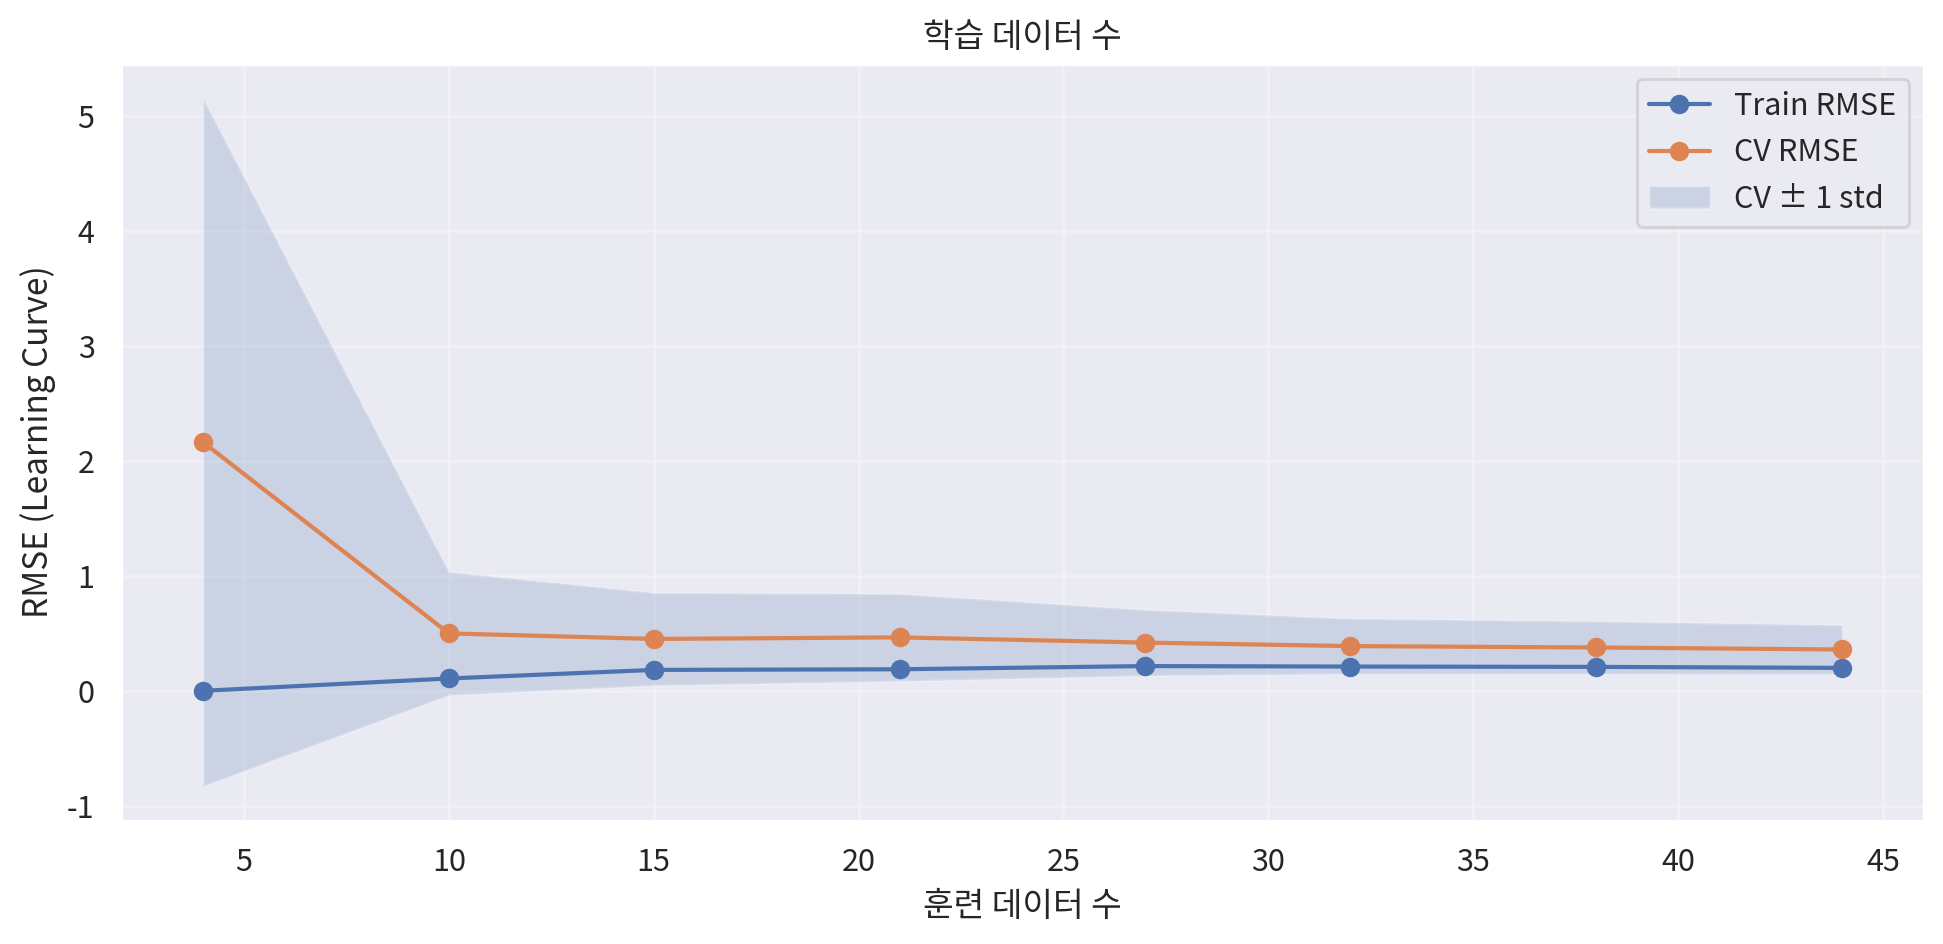

,지표,값
0,Train RMSE,0.199385
1,CV RMSE 평균,0.359186
2,CV RMSE 표준편차,0.213944
3,Train/CV 비율,0.555101
4,CV 변동성 비율,0.595635
5,판정 결과,❗ 과대적합 (일반화 실패)


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.model_selection import learning_curve

# =========================
# 1) Learning Curve 계산
# =========================
train_sizes, train_scores, cv_scores = learning_curve(
    estimator=estimator,             # 이미 정의된 모델 (예: LinearRegression(), Ridge() 등)
    X=X,                             # 특성
    y=y,                             # 타깃
    cv=5,                            # 5-fold
    scoring="neg_root_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 8),  # 학습 데이터 비율 10%~100%까지 8개 지점
    shuffle=True,
    random_state=52
)

# sklearn은 neg_RMSE로 반환 → 부호를 바꿔 RMSE로 복원
train_rmse = -train_scores
cv_rmse = -cv_scores

# 각 train_size 지점마다 fold 평균/표준편차
train_mean = train_rmse.mean(axis=1)
cv_mean = cv_rmse.mean(axis=1)
cv_std = cv_rmse.std(axis=1)

# =========================
# 2) 마지막 지점(학습 데이터 100%) 기준 지표 만들기
# =========================
final_train = train_mean[-1]   # 학습 데이터 최대일 때 Train RMSE 평균
final_cv = cv_mean[-1]         # 학습 데이터 최대일 때 CV RMSE 평균
final_std = cv_std[-1]         # 학습 데이터 최대일 때 CV RMSE 표준편차

# 상대 비교 지표(수업용 휴리스틱)
gap_ratio = final_train / final_cv     # Train/CV 비율 (1에 가까울수록 간격 작음)
var_ratio = final_std / final_cv       # CV 변동성 비율 (작을수록 안정)

# 기준값 (수업용 경험치)
LARGE = 1.2
SMALL = 0.9
STABLE = 0.10
UNSTABLE = 0.20

# =========================
# 3) 상태 판정 로직
# =========================
if gap_ratio >= LARGE and var_ratio <= STABLE:
    status = "⚠️ 과소적합 (모델이 너무 단순)"
elif gap_ratio <= SMALL and var_ratio >= UNSTABLE:
    status = "❗ 과대적합 (일반화 실패)"
elif gap_ratio <= SMALL and var_ratio <= STABLE:
    status = "✅ 일반화 양호"
elif gap_ratio <= SMALL and var_ratio > STABLE:
    status = "⚠️ 데이터 부족 (표본 문제)"
else:
    status = "⚠️ 판단 유보"

# =========================
# 4) 시각화 (Learning Curve)
# =========================
plt.figure(figsize=(10, 5))

# x축은 실제 학습 데이터 개수(행 수)
plt.plot(train_sizes, train_mean, marker="o", label="Train RMSE")
plt.plot(train_sizes, cv_mean, marker="o", label="CV RMSE")

# CV ± 1 std 영역
plt.fill_between(
    train_sizes,
    cv_mean - cv_std,
    cv_mean + cv_std,
    alpha=0.2,
    label="CV ± 1 std"
)

plt.title("학습 데이터 수")
plt.xlabel("훈련 데이터 수")
plt.ylabel("RMSE (Learning Curve)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# =========================
# 5) 정량 결과 표
# =========================
result_df = DataFrame({
    "지표": ["Train RMSE", "CV RMSE 평균", "CV RMSE 표준편차", "Train/CV 비율", "CV 변동성 비율", "판정 결과"],
    "값":  [final_train, final_cv, final_std, gap_ratio, var_ratio, status]
})

result_df


## #04. 과적합의 해결 방법
### (1) 과대적합
- 샘플 수를 늘려 모델이 충분히 학습할 수 있도록 함
- 훈련 데이터의 특성 수를 줄임 (차원 축소)
- 훈련 데이터의 잡음(노이즈)을 줄임 (이상치 제거)
- 파라미터 수가 적은 모델을 선택
- 모델을 단순화시킴
- 규제(Regularization) 적용
  - 불필요하게 큰 계수를 억제하여 모델 복잡도를 낮추고 일반화 성능을 개선
  - Ridge (L2 규제), Lasso (L1 규제), ElasticNet (L1 + L2) 등을 사용하여 계수를 제한함

> **결론:** 변수 수를 줄이거나 가중치를 제한하라는 뜻


### (2) 과소적합
- 변수의 수를 늘려 모델의 복잡도 증가
- 모델 파라미터가 더 많은 모델을 선택  
  (예: 단순 선형회귀 → 다항 회귀)
- 학습 알고리즘에 더 좋은 특성을 제공 (하이퍼파라미터 튜닝)
- 비선형 관계를 반영
- 규제 완화
  - 모델이 너무 단순해지지 않도록 계수 크기를 인위적으로 덜 억제
  - Ridge (L2 규제), Lasso (L1 규제), ElasticNet (L1 + L2)의 규제 강도 감소

> **결론:** 모델을 더 복잡하게 만들기 위해 변수를 늘리라는 뜻

### (3) 데이터 부족 대응
- 데이터 수집 확대
- 학습곡선으로 데이터 효과 확인
- 단일 분할 결과 맹신 금지